In [3]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
import os

## Analysis of the invasion probability ratio

In [16]:
# these two string must be passed during the execution of invasion_prob.exe
data_dir = '../data/inv_prob/LV4/'

### Setting the parameters

In [17]:
params = dict()

# General parameters
params['process_type'] = 'lv2'
params['N_init_cond'] = 3000 # -- Number of trajectories at each threshold
params['relax_step'] = 5000 # -- Number of steps for the relaxation of the initial condition
params['thresholds'] = [2, 5, 10, 20, 50, 100, 200, 400, 700, 1000, 2000, 5000, 10000] 

# Fixed parameters
rho2 = 1
chi2 = 1
s = 0.0
params['M'] = 500 # -- Population size scale

# List of parameters
chi1s = np.array([1/3, 1, 3])
rho1s = np.array(np.logspace(np.log10(0.2),np.log10(5),9))

params['N_processes'] = len(chi1s)*len(rho1s)

### Export for LV

In [18]:
count = 1
for c in chi1s:
    for r in rho1s:
        params['rhos'] = [r, rho2]
        params['chis'] = [c, chi2]
        params['fs'] = [1, 1-s]
        params['carrying_cap'] = params['M'] / chi2 / params['fs'][1]
        ut.write_params(params, data_dir, str(count)+'_param.txt')
        params['rhos'] = [rho2, r]
        params['chis'] = [chi2, c]
        params['fs'] = [1-s, 1]
        params['carrying_cap'] = params['M'] / c / params['fs'][1]
        ut.write_params(params, data_dir, str(count)+'sw_param.txt')
        count += 1

### Export for chemostat

In [17]:
count = 1
for c in chi1s:
    for r in rho1s:
        params['deltas'] = [r, rho2]
        params['etas'] = [r/c, rho2/chi2]
        params['alphas'] = [(1+s)*c, chi2]
        params['carrying_cap'] = params['M'] / chi2
        ut.write_params(params, data_dir, str(count)+'_param.txt')
        params['deltas'] = [rho2, r]
        params['etas'] = [rho2/chi2, r/c]
        params['alphas'] = [chi2, (1+s)*c]
        params['carrying_cap'] = params['M'] / c
        ut.write_params(params, data_dir, str(count)+'sw_param.txt')
        count += 1

### Importing the results and comparing with theory

In [2]:
plot_dir = '../plots/'
data_dir = '../data/inv_prob/'

In [4]:
def log_inv_prob_ratio(sM, r, c):
    if r != c:
        aux1 = sM * (r-1)/(r-c)
        aux2 = (sM*r*(c-1)-(1-r*c)*(r-c))/(c-r)**2 * np.log(c/r)
        return aux1+aux2
    else:
        return (sM*(r+1)/2+1-r**2)/r

In [3]:
ratio_at_sM = dict()
cs_at_sM, rs_at_sM = dict(), dict()
name_list = ['LV0', 'LV1', 'LV2']
n_max_files=25

for name in name_list:
    for i in range(1,n_max_files+1):
        try:
            inv_p = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'_inv_p.txt'))
            inv_p_sw = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'sw_inv_p.txt'))
            tparam = ut.read_params(data_dir+name+'/'+str(i)+'_param.txt')
            sMt = (tparam['fs'][0]-tparam['fs'][1])/tparam['fs'][1]* tparam['M']/tparam['chis'][1]
            if sMt not in ratio_at_sM:
                ratio_at_sM[sMt] = [inv_p / inv_p_sw]
                cs_at_sM[sMt] = [tparam['chis'][0]/tparam['chis'][1]]
                rs_at_sM[sMt] = [tparam['rhos'][0]/tparam['rhos'][1]]
            else:
                ratio_at_sM[sMt].append(inv_p / inv_p_sw)
                cs_at_sM[sMt].append(tparam['chis'][0]/tparam['chis'][1])
                rs_at_sM[sMt].append(tparam['rhos'][0]/tparam['rhos'][1])
        except:
            pass
            #print(i)

In [19]:
ratio_at_sM2 = dict()
cs_at_sM2, rs_at_sM2 = dict(), dict()
name_list = ['chem0', 'chem1', 'chem2']
n_max_files=25

for name in name_list:
    for i in range(1,n_max_files+1):
        try:
            inv_p = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'_inv_p.txt'))
            inv_p_sw = float(ut.read_inv_p(data_dir+name+'/'+str(i)+'sw_inv_p.txt'))
            tparam = ut.read_params(data_dir+name+'/'+str(i)+'_param.txt')
            rho0, rho1 = tparam['deltas'][0], tparam['deltas'][1]
            fs0, fs1 = tparam['etas'][0]*tparam['alphas'][0]/tparam['deltas'][0], tparam['etas'][1]*tparam['alphas'][1]/tparam['deltas'][1]
            chi0, chi1 = tparam['deltas'][0]/tparam['etas'][0], tparam['deltas'][1]/tparam['etas'][1]
            sMt = (fs0-fs1)/fs1* tparam['M']/chi1
            if sMt not in ratio_at_sM2:
                ratio_at_sM2[sMt] = [inv_p / inv_p_sw]
                cs_at_sM2[sMt] = [chi0/chi1]
                rs_at_sM2[sMt] = [rho0/rho1]
            else:
                ratio_at_sM2[sMt].append(inv_p / inv_p_sw)
                cs_at_sM2[sMt].append(chi0/chi1)
                rs_at_sM2[sMt].append(rho0/rho1)
        except:
            pass
            #print(i)

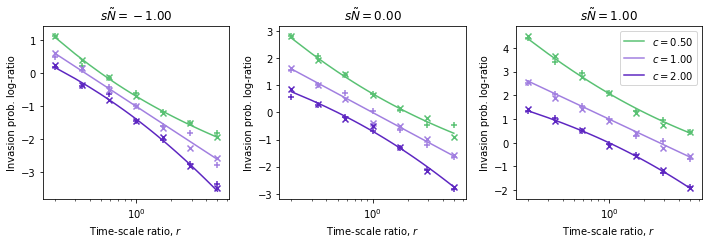

In [29]:
fig, axs = plt.subplots(1,len(ratio_at_sM2), figsize=(10,3.5))

colors = ['#59C173', '#a17fe0', '#5D26C1']
for i in range(len(ratio_at_sM2.keys())):
    sM = list(ratio_at_sM2.keys())[i]
    axs[i].set_title(r'$s \tilde{N}=%3.2f$'%sM)
    axs[i].set_xlabel('Time-scale ratio, $r$')
    axs[i].set_ylabel('Invasion prob. log-ratio')
    axs[i].set_xscale('log')
    unique_cs = set(cs_at_sM2[sM])
    count_c=0
    #unique_cs = [1.0,2.0,4.0]
    for c in unique_cs:
        ratio, r = np.array([]), np.array([])
        for k in range(len(ratio_at_sM2[sM])):
            if cs_at_sM2[sM][k] == c:
                ratio = np.append(np.log(ratio_at_sM2[sM][k]), ratio)
                r = np.append(rs_at_sM2[sM][k], r)
        axs[i].scatter(r, ratio, marker='+', c=colors[count_c])
        x = np.linspace(min(r), max(r))
        axs[i].plot(x, [log_inv_prob_ratio(sM, ar, c) for ar in x], label=r'$c=%3.2f$'%c, c=colors[count_c])
        count_c+=1
        
for i in range(len(ratio_at_sM.keys())):
    sM = list(ratio_at_sM.keys())[i]
    axs[i].set_title(r'$s \tilde{N}=%3.2f$'%sM)
    axs[i].set_xlabel('Time-scale ratio, $r$')
    axs[i].set_ylabel('Invasion prob. log-ratio')
    axs[i].set_xscale('log')
    unique_cs = set(cs_at_sM[sM])
    #unique_cs = [1.0,2.0,4.0]
    count_c=0
    for c in unique_cs:
        ratio, r = np.array([]), np.array([])
        for k in range(len(ratio_at_sM[sM])):
            if cs_at_sM[sM][k] == c:
                ratio = np.append(np.log(ratio_at_sM[sM][k]), ratio)
                r = np.append(rs_at_sM[sM][k], r)
        axs[i].scatter(r, ratio, marker='x', c=colors[count_c])
        count_c += 1

plt.legend()
plt.tight_layout()
plt.savefig(plot_dir+'p_inv_log_ratio.png', dpi=200, transparent=True)

In [18]:
beta2 = np.array([1,2,3,4,5])
data_dir = '../data/inv_prob/plotkin2/'

inv_p, inv_p_sw = [], []

count = 1
for i in range(len(beta2)):
    aux_p, aux_p_sw = [], []
    p = ut.read_params(data_dir + str(count) + '_param.txt')
    aux_p.append(float(ut.read_inv_p(data_dir + str(count) + '_inv_p.txt')))
    p = ut.read_params(data_dir + str(count) + 'sw_param.txt')
    aux_p_sw.append(float(ut.read_inv_p(data_dir + str(count) + 'sw_inv_p.txt')))
    count+=1
    inv_p.append(aux_p)
    inv_p_sw.append(aux_p_sw)

    
inv_p = np.array(inv_p)
inv_p_sw = np.array(inv_p_sw)

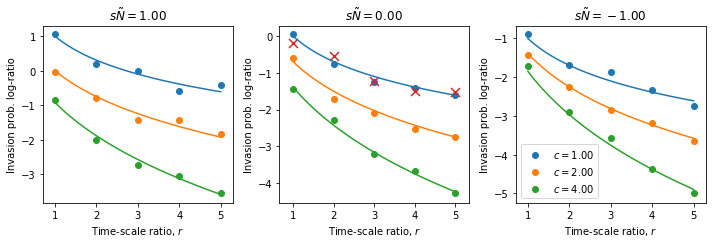

In [30]:
fig, axs = plt.subplots(1,len(ratio_at_sM), figsize=(10,3.5))

for i in range(len(ratio_at_sM.keys())):
    sM = list(ratio_at_sM.keys())[i]
    axs[i].set_title(r'$s \tilde{N}=%3.2f$'%sM)
    axs[i].set_xlabel('Time-scale ratio, $r$')
    axs[i].set_ylabel('Invasion prob. log-ratio')
    #unique_cs = set(cs_at_sM[sM])
    unique_cs = [1.0,2.0,4.0]
    for c in unique_cs:
        ratio, r = np.array([]), np.array([])
        for k in range(len(ratio_at_sM[sM])):
            if cs_at_sM[sM][k] == c:
                ratio = np.append(np.log(ratio_at_sM[sM][k]), ratio)
                r = np.append(rs_at_sM[sM][k], r)
        axs[i].scatter(r, ratio, label=r'$c=%3.2f$'%c)
        x = np.linspace(min(r), max(r))
        axs[i].plot(x, [log_inv_prob_ratio(sM, ar, c) for ar in x])
    

axs[1].scatter(beta2, np.log(inv_p_sw/inv_p), marker='x', s=80, label='Plotkin')
    
plt.legend()
plt.tight_layout()
plt.savefig(plot_dir+'p_inv_log_ratio.png', dpi=200, transparent=True)

### Analytical study

In [6]:
def alpha(c,r,sM):
    return (sM*(1+r)) / (c+r+r*c)

def ratio(c,r,sM):
    if c==0 and r==0:
        return 1
    return alpha(c,r,sM)*np.log(1+r) + (alpha(c,r,sM)-1)*np.log((1+c))

In [7]:
rs = [-0.95, 0, 20]
sMs = np.linspace(0,20,100)
cs = np.linspace(0,20,100)

x_mat, y_mat, z_mat = [], [], []
for r in rs:
    aux_x_mat, aux_y_mat, aux_z_mat = [], [], []
    for sM in sMs:
        aux2_x_mat, aux2_y_mat, aux2_z_mat = [], [], []
        for c in cs:
            aux2_x_mat.append(sM)
            aux2_y_mat.append(c)
            aux2_z_mat.append(ratio(c,r,sM))
        aux_x_mat.append(aux2_x_mat)
        aux_y_mat.append(aux2_y_mat)
        aux_z_mat.append(aux2_z_mat)
    x_mat.append(aux_x_mat)
    y_mat.append(aux_y_mat)
    z_mat.append(aux_z_mat)

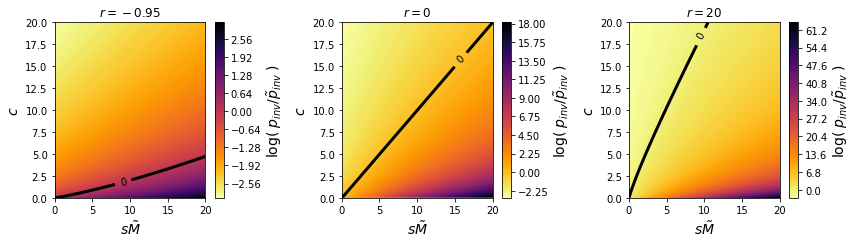

In [8]:
fig, axs = plt.subplots(1,3,figsize=(12,3.5))
maxz = np.max(z_mat)
minz = np.min(z_mat)

for i in range(len(rs)):
    axs[i].set_xlabel(r'$s \tilde{M}$', fontsize=14)
    axs[i].set_ylabel(r'$c$', fontsize=14)
    axs[i].set_title(r'$r={}$'.format(rs[i]))
    cntf = axs[i].contourf(x_mat[i], y_mat[i], z_mat[i], levels=200, cmap='inferno_r')
    cnt = axs[i].contour(x_mat[i], y_mat[i], z_mat[i], levels=[0], colors='black', linewidths=3)
    axs[i].clabel(cnt, fmt='%2.0f')
    
    cb = plt.colorbar(cntf, ax=axs[i])
    cb.set_label(r'$\log(\;p_{inv}/\tilde{p}_{inv}\;)$', fontsize=14)
plt.tight_layout()
#plt.savefig(plot_dir+'phd.png',dpi=200)

In [33]:
def zipf(i, g1, g2, k, istar, istar2, A):
    if i<=istar:
        return A * i**(-g1)
    elif i>istar and i<=istar2:
        return A * istar**(g2-g1) * i**(-g2)
    else:
        B = A * istar**(g2-g1)
        return B * istar2**(-g2) * np.exp(k*(istar2 - i)) 


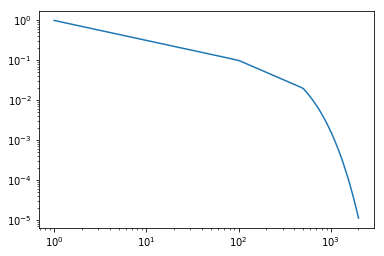

In [43]:
x = np.linspace(1,2000, 100)
istar=100
istar2=500
g1=0.5
g2=1
A = 1
k = 0.005
z = [zipf(i, g1, g2, k, istar, istar2, A) for i in x]

plt.xscale('log')
plt.yscale('log')
plt.plot(x, z)